<a href="https://colab.research.google.com/github/surabhithakare2128/TensorFlow/blob/master/Clothing_Image_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clothing Image Classification using CNN

## The dataset used is TensorFLow dataset named Fashion MNIST
### There are 70,000 images of various items like T-shirt, sneakers, ankle boot, etc in the dataset. 60,000 of which will be used as Training data and rest 10,000 approx 15% of the images will be used as Testing data
### Here we will perform "flattening" to convert 2D image into vector. The 28*28 pixel image will be converted into vector of 728 elements using Flatten layer
## Following steps are performed to build and train this network:
#### 1. Importing necessary libraries and dataset
#### 2. Loading dataset from tensorflow
#### 3. Exploring data
#### 4. Pre-processing data
#### 5. Exploring Pre-processed data
#### 6. Building Model
#### 7. Training Model
#### 8. Evaluating Model
#### 9. Making Predictions

## Importing tensorflow and required libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow_datasets as tfds


# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print("Version of TensorFlow is: "+tf.__version__)

tf.enable_eager_execution()  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Version of TensorFlow is: 1.13.1


## Importing Fashion MNIST Dataset

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [5]:
print(metadata)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)
    },
    total_num_examples=70000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=60000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @article{DBLP:journals/corr/abs-1708-07747,
          author    = {Han Xiao and
                       Kashif Rasul and
                       Roland Vollgraf},
          title     = {Fashion-MNIST: a Novel Image Dataset for Benchmark

### Loading dataset returns metadata, training dataset as well as testing dataset

### Each image is mapped to a single label. Since the *class names* are not included with the dataset,  we will store them here to use later when plotting the images:

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Explore the data

### Metadata tells there are 60000 train images and 10000 test images, retrieving that information using num_examples

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [8]:
metadata.splits

{'test': <tfds.core.SplitInfo num_examples=10000>,
 'train': <tfds.core.SplitInfo num_examples=60000>}

## Pre-process the Data
### As the value of each pixel ranges between (0, 255) we need to normalize it to range (0, 1)

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

## Exploring the processed data
### See what the images look like

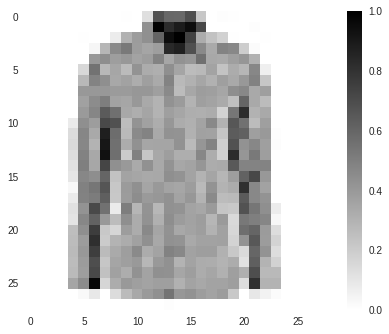

In [10]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

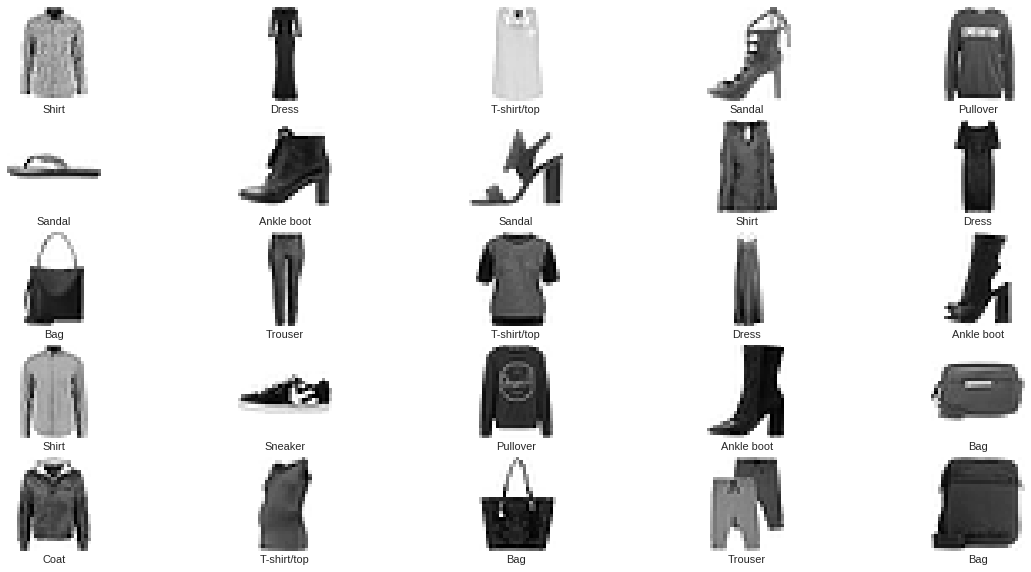

In [11]:
# Displaying first 25 images
plt.figure(figsize=(20,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Building the model

### Setup layers

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

### Compiling the Model

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

First, I defined the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.
4. The `steps_per_epoch` shows the total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. 

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.4052 - acc: 0.8545
Epoch 2/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2649 - acc: 0.9031
Epoch 3/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2177 - acc: 0.9199
Epoch 4/5
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1866 - acc: 0.9316
Epoch 5/5
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1615 - acc: 0.9404


### The above output shows that the model has reached the accuracy of 94% whereas dense network gave an accuracy 82.5%

## Evaluate Accuracy using Test Dataset

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 11ms/step - loss: 0.2511 - acc: 0.9174
Accuracy on test dataset: 0.9174


### This shows that the accuracy on test dataset has gone down by approx 3%

## Making Predictions using Model

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [18]:
predictions.shape


(32, 10)

In [19]:
predictions[0]

array([7.36641668e-05, 1.04853255e-08, 2.37187371e-03, 3.48075737e-05,
       8.69775862e-02, 1.32657210e-08, 9.10541654e-01, 2.60947641e-09,
       2.62009195e-07, 1.57688930e-07], dtype=float32)

In [20]:
np.argmax(predictions[0])

6

### The above output shows that image belongs to 6th category

In [21]:
class_names[6] #printing 6th category which is a shirt

'Shirt'

### We can use the following function to graph the image and predictions

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

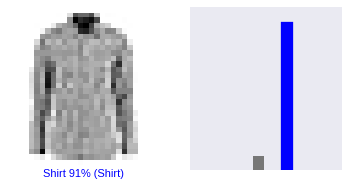

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

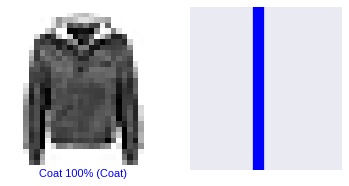

In [25]:
i = 20
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

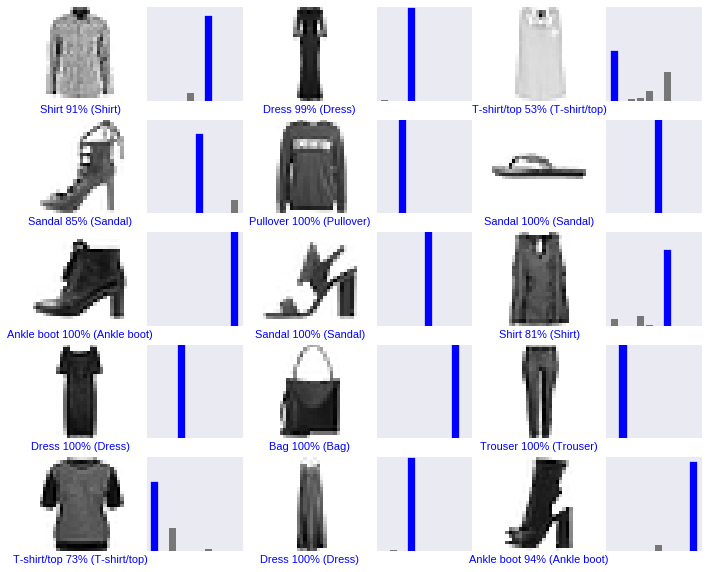

In [26]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)



# This shows that CNN made no error whereas deep network made 3 errors

Using the trained model to make a prediction about a single image. 

In [27]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [28]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [29]:
#predicting the image
predictions_single = model.predict(img)

print(predictions_single)

[[7.3664218e-05 1.0485324e-08 2.3718742e-03 3.4807599e-05 8.6977735e-02
  1.3265718e-08 9.1054147e-01 2.6094660e-09 2.6200888e-07 1.5768860e-07]]


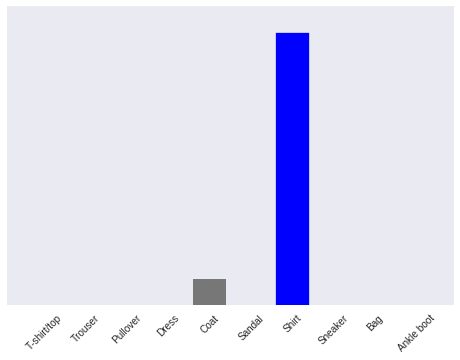

In [30]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [31]:
np.argmax(predictions_single[0])

6